## Homogeneous incompressible Earth model

COMMAND 

$\newcommand{\md}{\mathrm{d}\hspace{0cm}}$
$\newcommand{\grad}{\boldsymbol{\nabla}\hspace{-0.01cm}}$
$\newcommand{\stress}{\boldsymbol{\sigma}}$
$\newcommand{\bn}[1]{\hat{\mathbf{#1}}}$
$\newcommand{\bb}[1]{\mathbf{#1}}$
$\newcommand{\sn}[1]{\hat{\boldsymbol{#1}}}$
$\newcommand{\sb}[1]{\boldsymbol{#1}}$
$\newcommand{\zero}{\mathbf{0}}$
$\newcommand{\one}{\mathbf{1}}$
$\newcommand{\loc}{\Delta\hspace{0cm}}$
$\newcommand{\mat}{\delta\hspace{0cm}}$
$\newcommand{\det}{\mathrm{\det}\hspace{0cm}}$
$\newcommand{\cm}[1]{\bar{\bb{#1}}}$
$\newcommand{\lmsum}{\sum_{n=0}^\infty\sum_{m=-n}^n}$
$\newcommand{\kqsum}{\sum_{k=0}^\infty\sum_{q=-k}^k}$


In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#######################################
def label_Loves(ax,maxwells=None,times=None,logy_time=False,logy_det=False):
    
    axes[0].set_title("LOAD")
    axes[3].set_title("TIDAL")

    if logy_time:
        for ax,label in zip(axes[:3],["$(H\star h_n)(t)$","$(H\star l_n)(t)$","$H(t)+(H\star k_n)(t)$"]):
            ax.set_ylabel(label)
    else:
        if logy_det:
            labels = ["$\\tilde{h}_n(s)\,\Delta(s)$","$\\tilde{l}_n(s)\,D(s)$","$(1+\\tilde{k}_n(s))\,D(s)$"]
        else:
            labels = ["$\\tilde{h}_n(s)$","$\\tilde{l}_n(s)$","$1+\\tilde{k}_n(s)$"]
        for ax,label in zip(axes[:3],labels):
            ax.set_ylabel(label)
        
    if times is not None:
        for ax in axes:
            label = "Relaxation time"
            for time in times:
                if logy_time:
                    ax.axvline(time,linewidth=0.8,color="red",label=label)
                else:
                    ax.axvline(1/time,linewidth=0.8,color="red",label=label)
                label = None
    
    if maxwells is not None:
        for ax in axes:
            label = "Maxwell time"
            for maxwell in maxwells:
                if logy_time:
                    ax.axvline(maxwell,linewidth=0.8,color="blue",label=label)
                else:
                    ax.axvline(1/maxwell,linewidth=0.8,color="blue",label=label)
                label = None
    
    if maxwells is not None or times is not None: 
        for ax in axes:
            ax.legend()

    for ax in axes[[2,5]]:
        if logy_time:
            ax.set_xlabel("Time $t$  [yr]")
        else:
            ax.set_xlabel("Laplace variable $-s$  [1/yr]")
#######################################


#######################################
def label_Det(ax,maxwells=None,times=None):
    
    ax.set_ylabel("Determinant $|D(s)|$")
    ax.set_xlabel("Laplace variable $-s$  [1/yr]")    
        
    if times is not None:
        label = "Relaxation time"
        for time in times:
            ax.axvline(1/time,linewidth=0.8,color="red",label=label)
            label = None
    
    if maxwells is not None:
        label = "Maxwell time"
        for maxwell in maxwells:
            ax.axvline(1/maxwell,linewidth=0.8,color="blue",label=label)
            label = None

    if maxwells is not None or times is not None: 
        ax.legend()
#######################################

Let us define a function collecting the Earth model parameters

In [3]:
#######################################
def get_param():

    DENSITY  = 5000
    SHEAR    = 70e9
    LENGHT   = 6371e3
    VEL = np.sqrt(SHEAR/DENSITY)
    ACC = VEL**2 / LENGHT
    UNI = ACC/(DENSITY*LENGHT)    
    
    a = 6371e3   / LENGHT
    density = 5e3    / DENSITY
    shear = 90e9     / SHEAR
    viscosity = 1e21 / SHEAR

    c = 4*np.pi*6.67430e-11 / UNI

    gravity = c*density*a/3 
    year = 365.25 * 24 * 3600
    maxwell = viscosity/shear/year  # yr

    return a, c, density, gravity, shear, maxwell
#######################################

and use it for calculating the fundamental regular $6\times3$-matrix $\bar{Y}_n(a)$ given by eq. 

In [4]:
#######################################
def eva_Y(s,n):
    
    gamma = np.sqrt(n*(n+1))
    
    a, c, density, gravity, shear, maxwell = get_param()
    
    dg = density*gravity
    
    if abs(s) == np.inf:
        eq_shear = shear
    else:
        eq_shear = shear*s/(s+1/maxwell) 
    
    Y = np.array( [ [1,    1,   0],
                    [(n+3)/gamma,   (n+1)/gamma,  0],
                    [0,0,1],
                    [dg + 2*((n-1)*n-3)*eq_shear/n/a, dg + 2*(n-1)*eq_shear/a, density],
                    [2*n*(n+2)*eq_shear/a/gamma, 2*(n**2-1)*eq_shear/a/gamma, 0],
                    [c*density, c*density, (2*n+1)/a]])

    return Y
#######################################                                      

We then define the function calculating the load and tidal boundary condition vectors $\mathbf{b}_n^L$ and $\mathbf{b}_n^T$ and a function for transforming the solution into Love numbers

In [5]:
#######################################                    
def eva_Boundary(n):    
    
    a, c, density, gravity, shear, maxwell = get_param()

    BL = (2*n+1)/a * np.array([ gravity/c, 0, 1 ])
    BT = (2*n+1)/a * np.array([ 0, 0, 1] )
    
    return BL, BT
#######################################                    

#######################################                    
def make_Love(y):
    a, c, density, gravity, shear, maxwell = get_param()
    K = y.copy()
    K[[0,1,3,4]] *= - gravity
    return K
#######################################  

We can now implement eq. and obtain the solution satisfying the load and tidal boundary conditions and, so, obtain the load an tidal Love numbers

In [6]:
#######################################                    
def eva_Loves(s,n):
    
    Y = eva_Y(s,n)
    BL, BT = eva_Boundary(n)

    P2Y = Y[3:]
    P1Y = Y[:3]
    Z = P1Y @ np.linalg.inv(P2Y) 

    YL = Z @ BL
    YT = Z @ BT
    Y = np.append(YL,YT)
    K = make_Love(Y.flatten())
    
    return K
#######################################                    

Using this function for $s=\infty$, we obtain the elastic Love numbers

In [7]:
import numpy as np
n = 2
KE = eva_Loves(np.inf,n)
print(KE)

[-0.41523258 -0.30513238  0.75086045  0.62284887  0.45769857  1.37370932]


We then implement the analytical expression for the elastic Love numbers

In [8]:
def eva_Love_ana(n,s=np.inf):
    
    a, c, density, gravity, shear, maxwell = get_param()
    
    
    if abs(s) == np.inf:
        eq_shear = shear
    else:
        eq_shear = shear*s/(s+1/maxwell) 

    gamma = np.sqrt(n*(n+1))
    
    alpha = 1 + (2*n**2+4*n+3)*eq_shear/(n*a*density*gravity)
    
    KL = -1/alpha * np.array([(2*n+1)/3,(n+1)/gamma,1])
    KT = 1/alpha/(n-1) * np.array([(2*n+1)/2,3*(n+1)/2/gamma,3/2])
    
    KL[2] += 1
    KT[2] += 1
    
    K = np.append(KL,KT)

    return K

and check that our previous results coincide with the analytical expressions

In [9]:
KE_ana = eva_Love_ana(n)
print(KE)
print(KE_ana)

[-0.41523258 -0.30513238  0.75086045  0.62284887  0.45769857  1.37370932]
[-0.41523258 -0.30513238  0.75086045  0.62284887  0.45769857  1.37370932]


In [10]:
np.set_printoptions(precision=5,suppress=True)
KF_ana = eva_Love_ana(n,0)
print(KF_ana)
print(eva_Loves(1e-12,n))

[-1.66667 -1.22474  0.       2.5      1.83712  2.5    ]
[-1.66667 -1.22474  0.       2.5      1.83712  2.5    ]


Let us now (i) obtain the characteristic relaxation time of the homogeneous viscoelastic Earth model

In [11]:
a, c, density, gravity, shear, maxwell = get_param()

gamma = np.sqrt(n*(n+1))

alpha = 1 + (2*n**2+4*n+3)*shear/(n*a*density*gravity)
relax_time = maxwell*alpha 

(ii) calculate the viscoelastic Lov number on the negative half of the real axis of the Laplace domain

In [76]:
ss = - 10**np.linspace(-5,-1,10001)

Ks = np.empty(ss.shape+(6,))
for i,s in enumerate(ss):
    Ks[i] = eva_Loves(s,n)

and (iii) plot them

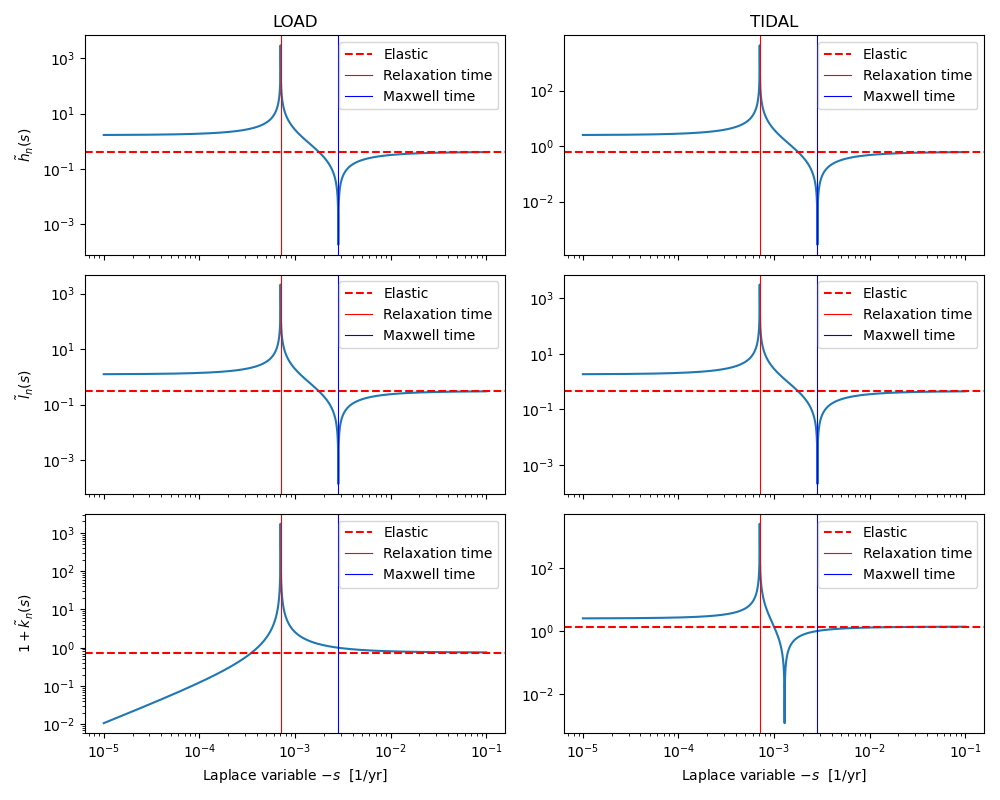

In [13]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(3,2,tight_layout=True,sharex=True,figsize=(10,8))
axes = axes.T.flatten()

for k,ax in enumerate(axes):
    
    ax.loglog(-ss,abs(Ks[:,k]))
    ax.axhline(abs(KE[k]),color="red",linestyle="dashed",label="Elastic")
    
label_Loves(axes,[maxwell],[relax_time])

As we can see, all the viscoelastic Love numbers has a singularity in correspondence of the characteristic relaxation time, at $s_0=-1/\tau_n$ with $\tau_n=\alpha_n\,\tau$. Moreover, despite the fact that the Maxwell time $\tau$ is a singularity for the equivalent shear modulus $\hat{\mu}(s)=\mu\,s/(s+1/\tau)$, the corresponding Laplace variable $s=-1/\tau$ does not constitute a singularity for the Love numbers.

According to eq. , the viscoelastic Love numbers can be cast as follows
$$
\begin{align}
\tilde{\mathbf{k}}_n^X(s) = \frac{\mathbf{r}^X(s)}{\Delta(s)}
\end{align}
$$

with

$$
\mathbf{r}^X(s) = \mathbf{P}_1\,\mathbf{Y}_n(a)\,\big[\mathbf{P}_2\,\mathbf{Y}_n(a)\big]^\dagger\,\mathbf{b}_n^X \qquad \Delta(s) = \mathrm{det}\big[\mathbf{P}_2\,\mathbf{Y}_n(a)\big]
$$

Within the assumption that they are characterized only by first-order poles $s_j$ ($j=0,N-1$), we can also write

$$
\tilde{\mathbf{k}}(s) = \sum_{j=0}^{N-1}\frac{\mathbf{k}_j}{s-s_j} + \mathbf{k}_E
$$

Let us now expand eq. {eq}`EQ` around $s=s_k$ as follows

$$
\begin{align}
\tilde{\mathbf{k}}(s_k+\delta s) &= \frac{\mathbf{k}_k}{\delta s} + \sum_{j\neq k}\frac{\mathbf{k}_j}{s_k-s_j}\,\left(1-\frac{\delta s}{s_k-s_j}\right)+ \mathbf{k}_E
= \frac{\mathbf{k}_k}{\delta s} + \sum_{j\neq k}\frac{\mathbf{k}_j}{s_k-s_j} + \mathbf{k}_E + (1-\delta_{N,1})\,O(\delta s)
\end{align}
$$

where the first order term is present only when there are more than one pole, i.e., for $N\geq 2$.

Furtheremore, let us also consider the following Taylor expansions

$$
\mathbf{r}^X(s_k+\delta s) =\mathbf{r}^X(s_k) + \dot{\mathbf{r}}^X(s_k)\,\delta s + O\big(\delta s^2\big)
\qquad
\Delta(s_k+\delta s) =  \dot{\Delta}_n(s_k)\,\delta s + O\big(\delta s^2\big) = \delta s\,\dot{\Delta}_n(s_k) \left[1 + \frac{O(\delta s)}{\dot{\Delta}_n(s_k)}\right]
$$

and make use them in eq. {eq}`EQ`

$$
\begin{align}
\tilde{\mathbf{k}}_n^X(s_k+\delta s) = \frac{\mathbf{r}_0^X(s_k)}{\dot{\Delta}(s_k)\,\delta s}\,\left(1 - \frac{O\big(\delta s\big)}{\dot{\Delta}(s_k)}\right) + \frac{\dot{\mathbf{r}}^X(s_k)}{\dot{\Delta}(s_k)}\,\left[1 - \frac{O(\delta s)}{\dot{\Delta}_n(s_k)}\right] + O(\delta s) = \frac{\mathbf{r}_0^X(s_k)}{\dot{\Delta}(s_k)\,\delta s} + \frac{\dot{\mathbf{r}}^X(s_k)}{\dot{\Delta}(s_k)} + O(\delta s)
\end{align}
$$

By comparing eqs. {eq}`EQ` and {eq}`EQ`, we note that 

$$
\frac{\dot{\mathbf{r}}^X(s_k)}{\dot{\Delta}(s_k)} = \sum_{j\neq k}\frac{\mathbf{k}_j}{s_k-s_j} + \mathbf{k}_E
$$

and that the residues $\mathbf{k}_j$ are given by

$$
\mathbf{k}_k =  \frac{\mathbf{r}_0^X(s_k)}{\dot{\Delta}(s_k)}
$$

Thanks to this latter result, we thus have a simple procedure for calculating the residues $\mathbf{k}_j$, once the poles $s_k$ have be determined. 

In this perspective, we define the following function for evaluating the determinant $\Delta(s)$ or its derivative

In [14]:
#######################################                    
def eva_Det(s,n,eps=None):
    
    if eps is None:
        
        Y = eva_Y(s,n)
        P2Y = Y[3:]
        D = np.linalg.det(P2Y) 

    else:
        
        Y = eva_Y(s+eps,n)
        P2Y = Y[3:]
        D1 = np.linalg.det(P2Y) 
        
        Y = eva_Y(s-eps,n)
        P2Y = Y[3:]
        D0 = np.linalg.det(P2Y) 
    
        D = (D1-D0)/(2*eps)
        
    return D
####################################### 

and we use it for sampling the determinant on the negative half of the real axis of the Laplace domain

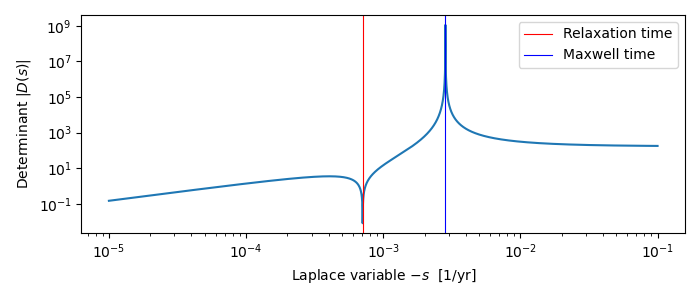

In [15]:
Ds = np.empty(ss.shape)
for i,s in enumerate(ss):
    Ds[i] = eva_Det(s,n)
    
fig,ax = plt.subplots(tight_layout=True,figsize=(7,3))
ax.loglog(-ss,abs(Ds))
label_Det(ax,[maxwell],[relax_time])

As expected, the determinant has a root in corresponde of the relaxation time and, as we can see, it is its only root. In addition to its analytical expression $s_0=\alpha_n\,\tau$, it can be also found numerically using roor finding algorithms as those provided by the subpackage `scipy.optimize` 

In [16]:
from scipy import optimize
eps= 1e-5
root = optimize.brentq(eva_Det,-eps,-1/maxwell+eps,args=(n,))
print(-1/root,relax_time)

1413.2235131896384 1413.2235135796159


Let us now define the subroutings for computing the minor and the numerator of eq. for both load and tidal forcings

In [17]:
def adjoint(A):
    """
    \n\n It return the adjoint matrix M of a real square matrix A.
    """
    
    N = len(A)
    M = np.empty(A.shape,dtype=A.dtype)
    for i in range(N):
        for j in range(N):
            Q = np.delete(np.delete(A,i,axis=0),j,axis=1)
            M[j,i] = np.linalg.det(Q)
            if (i+j)%2 == 1: M[j,i] = -M[j,i]
    return M

#######################################                    
def eva_Num(s,n):
    """
    \n\n It return the numerator ... 
    """

    BL, BT = eva_Boundary(n)

    Y = eva_Y(s,n)
    P2Y = Y[3:]
    P1Y = Y[:3]
    Z = P1Y @ adjoint(P2Y) 

    YL = Z @ BL
    YT = Z @ BT
    Y = np.append(YL,YT)
    K = make_Love(Y)
    
    return K
#######################################                    

and use them for sampling and plotting the numerators over the negative half of the real axis of the Laplace domain and 

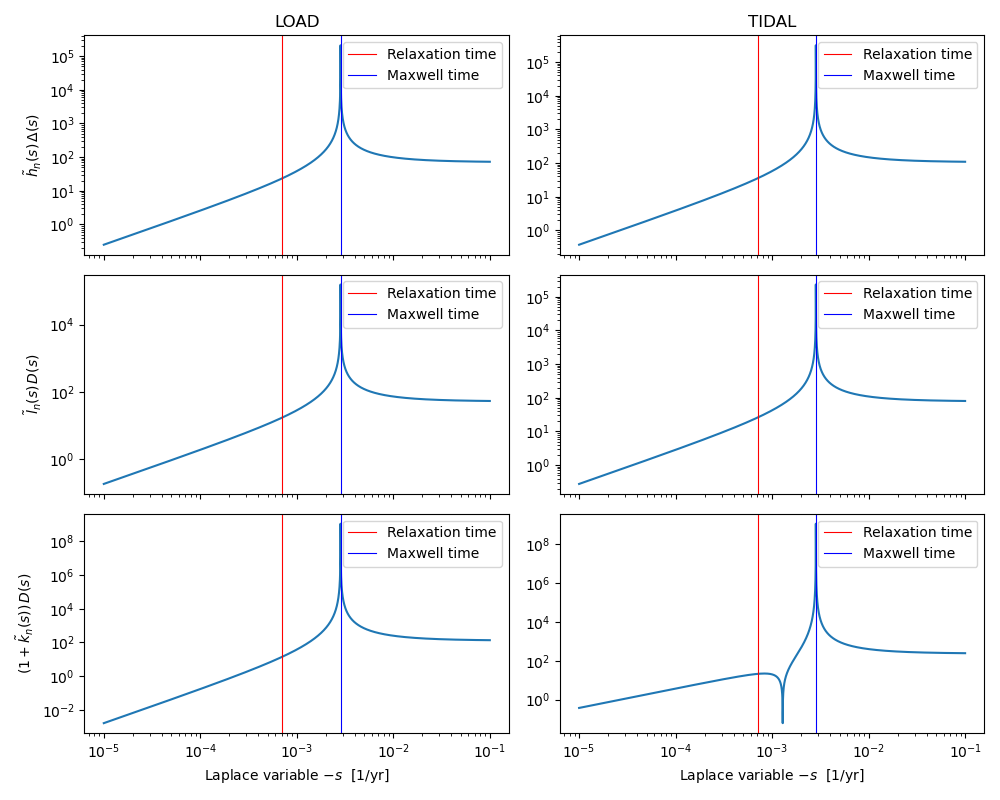

In [18]:
nums = np.empty(ss.shape+(6,))
for i,s in enumerate(ss):
    nums[i] = eva_Num(s,n)
    
fig,axes = plt.subplots(3,2,tight_layout=True,sharex=True,figsize=(10,8))
axes = axes.T.flatten()

for k,ax in enumerate(axes):
    ax.loglog(-ss,abs(nums[:,k]))
    
label_Loves(axes,[maxwell],[relax_time],logy_det=True)

In the perspective of calculating the derivative of the secular determinant $\Delta$, we test different increments and conclude that an increment of the order of $10^{-9}\,\mathrm{yr}^{-1}$ is reasonable 

In [19]:
for eps in np.arange(-15,-1):
    eps = 1e1**eps
    DER = eva_Det(s,n,eps)
    print(eps,DER)

1e-15 0.0
1e-14 -95.21272659185342
1e-13 -92.51266419596504
1e-12 -92.2142362469458
1e-11 -92.21707841788884
1e-10 -92.21082564181415
1e-09 -92.21190566677251
1e-08 -92.21188435049044
1e-07 -92.211886055793
1e-06 -92.21188601316044
1e-05 -92.21188698660397
0.0001 -92.21198606070402
0.001 -92.22189417408799
0.01 -93.22356869206061


We then calculate the derivative of the secular determinant for such an increment and obtain the residue, as well as the fluid Love numbers,

In [20]:
eps = 1e-9
DER = eva_Det(root,n,eps)
K_num = eva_Num(root,n)

R = K_num/DER

KF = KE - R/root

and check that the representation of the Love numbers as the sum of the elastic response and the first order pole is correct

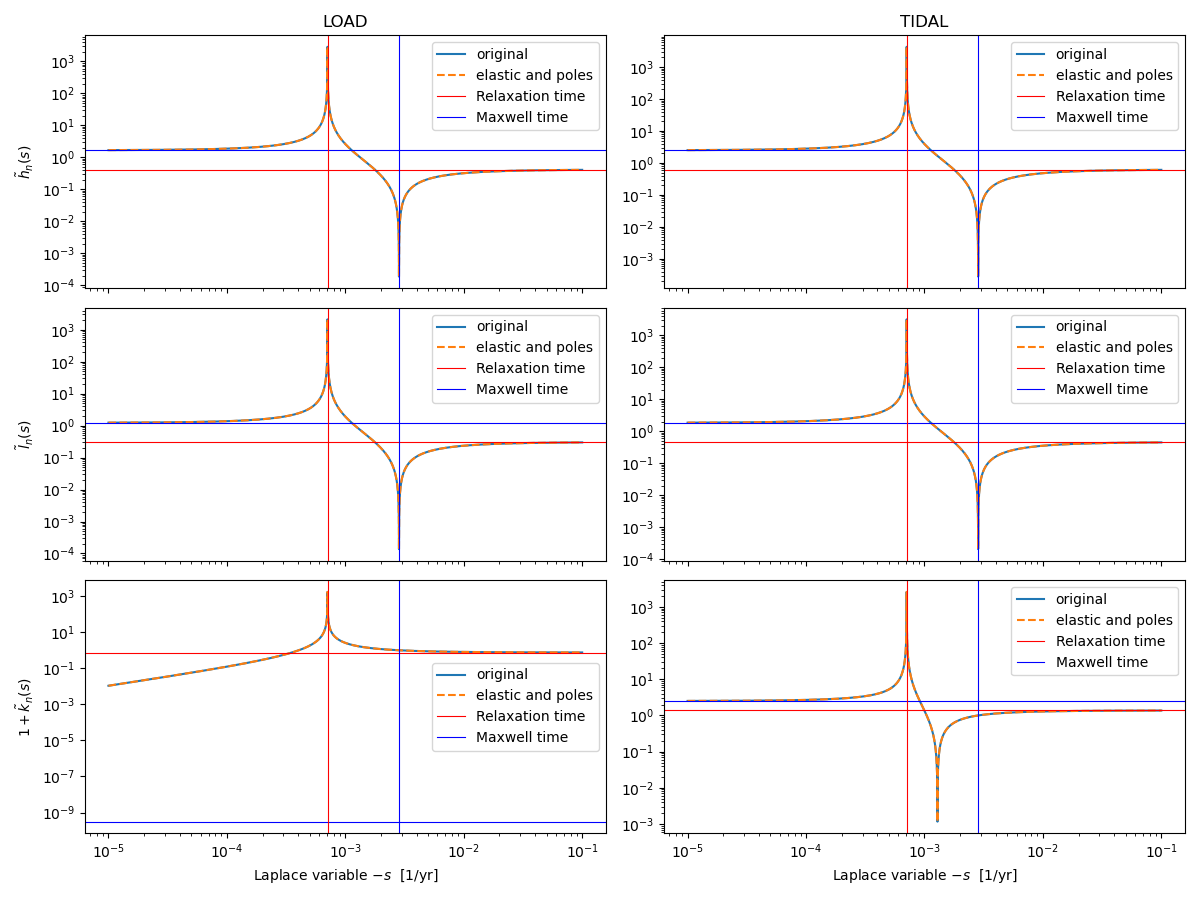

In [21]:
Ks_check = np.tensordot(1/(ss-root),R,axes=0) + KE

fig,axes = plt.subplots(3,2,tight_layout=True,sharex=True,figsize=(12,9))
axes = axes.T.flatten()

for k,ax in enumerate(axes):
    ax.loglog(-ss,abs(Ks[:,k]),label="original")
    ax.loglog(-ss,abs(Ks_check[:,k]),linestyle="dashed",label="elastic and poles")

    ax.axhline(abs(KF[k]),linewidth=0.8,color="blue")
    ax.axhline(abs(KE[k]),linewidth=0.8,color="red")

label_Loves(axes,[maxwell],[relax_time])

We also note that the Love numbers in the limits of $\mid\,s\mid \rightarrow\infty$ and $s\rightarrow0$ yield the elastic and fluid Love numbers.


Let us now calculate and plot the time convolution of the Love numbers with a step-like time history

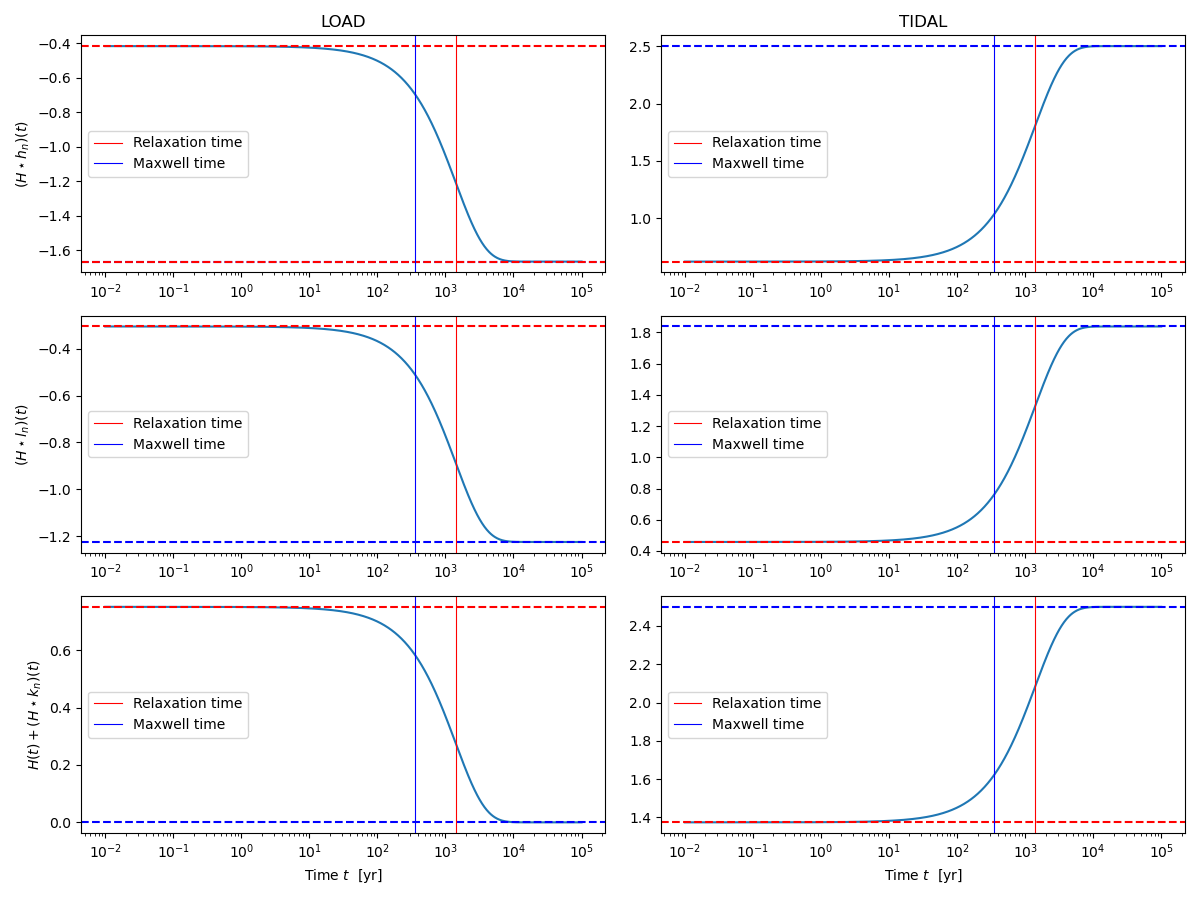

In [22]:
ts = 1e1**np.linspace(-2,5,1001)
K_times = np.tensordot(1-np.exp(root*ts),-R/root,axes=0) + KE

fig,axes = plt.subplots(3,2,tight_layout=True,figsize=(12,9))
axes = axes.T.flatten()

for k,ax in enumerate(axes):
    ax.semilogx(ts,K_times[:,k])

    ax.axhline(KF[k],color="blue",linestyle="dashed")
    ax.axhline(KE[k],color="red",linestyle="dashed")
    if k==0: ax.axhline(-5/3,color="red",linestyle="dashed")
    
label_Loves(axes,[maxwell],[relax_time],True)

In [23]:
Y0_homo = eva_Y(1e-10,n)
print(Y0_homo)

[[ 1.       1.       0.     ]
 [ 2.04124  1.22474  0.     ]
 [ 0.       0.       1.     ]
 [ 4.05277  4.05277  1.     ]
 [ 0.       0.       0.     ]
 [12.1583  12.1583   5.     ]]


## Layered incompressible Earth model

Let us now consider a three layered Earth models composed of an inviscid core and a viscoelastic mantle and lithosphere and define the subroutine for obtaining the relevant  material parameters within each layer

In [24]:
DENSITY  = 5000
SHEAR    = 70e9
LENGHT   = 6371e3
VEL = np.sqrt(SHEAR/DENSITY)
ACC = VEL**2 / LENGHT
UNI = ACC/(DENSITY*LENGHT)    

print(DENSITY,SHEAR,LENGHT,VEL,ACC,UNI)

5000 70000000000.0 6371000.0 3741.657386773941 2.1974572280646676 6.89831181310522e-11


In [92]:
def get_param_core():

    density_core = 10e3     / DENSITY
    c = 4*np.pi*6.67430e-11 / UNI
    b = 3480e+3             / LENGHT
    
    gravity_core = c*density_core*b/3

    #print( "core",c,b,density_core,gravity_core)
    return c,b,density_core,gravity_core

def get_param_mantle():

    c,b,density_core,gravity_core = get_param_core()
    
    m = ( 6371e3 - 120e3 )  / LENGHT
    density_mantle = 4.75e3    / DENSITY
    shear_mantle = 90e9     / SHEAR
    viscosity_mantle = 1e21 / SHEAR
    
    year = 365.25*24*3600    
    
    maxwell_mantle = viscosity_mantle/shear_mantle/year
    
    gravity_mantle = c/m**2 * ( density_mantle*(m**3-b**3) ) / 3  + gravity_core * b**2/ m**2
    
    #print( "mantle",c,m,b,density_mantle,gravity_mantle,gravity_core,shear_mantle,maxwell_mantle)
    return c,m,b,density_mantle,gravity_mantle,gravity_core,shear_mantle,maxwell_mantle

def get_param_litho():

    c,m,b,density_mantle,gravity_mantle,gravity_core,shear_mantle,maxwell_mantle = get_param_mantle()
    
    a = 6371e3              / LENGHT
    density_litho = 3e3     / DENSITY
    shear_litho = 50e9      / SHEAR
    viscosity_litho = 5e22  / SHEAR
    year = 365.25*24*3600   
    
    maxwell_litho = viscosity_litho/shear_litho/year
    
    gravity_litho = c/a**2 * ( density_litho*(a**3-m**3) ) / 3  + gravity_mantle * m**2/ a**2
    
    #print( "litho",c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho)
    return c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho

In [113]:
c,b,density_core,gravity_core = get_param_core()
c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho = get_param_litho()
c,m,b,density_mantle,gravity_mantle,gravity_core,shear_mantle,maxwell_mantle = get_param_mantle()
print(gravity_core,gravity_mantle,gravity_litho)

I0 = density_core*b**5 + density_mantle*(m**5-b**5) + density_litho*(a**5-m**5)
I0 /= 5
I0 *= 8*np.pi/3
I0 *= DENSITY*LENGHT**5
print(I0)
print(gravity_litho*ACC)

4.427444708888827 4.498006129594454 4.4649905336375
8.523550857271337e+37
9.811625721382041


In [116]:
KE-1

array([-1.7496 , -1.49331, -0.40973, -0.07504, -0.50501,  0.51522])

# w0 = 2*np.pi/(24*3600)
CA = w0**2*(a*LENGHT)**5/6.6743e-11/3*(KF[-1]-1)
print(CA)
A=I0 - CA/3
print(A)
print(I0 + 2*CA/3)
we = w0*CA/A
wc = we*(1-(KE[-1]-1)/(KF[-1]-1))
print(we,wc)
print(1/(we/(2*np.pi))/24/3600/365.25)
print(1/(wc/(2*np.pi))/24/3600/365.25)

Then, we implement the CMB matrix

In [27]:
def eva_CMB(n):

    c,b,density,gravity = get_param_core()

    PSI = 1
    Q = 2*(n-1)/b
    
    CMB = np.array([ [-PSI/gravity,0,1],
                     [0,1,0],
                     [PSI,0,0],
                     [0,0,density*gravity],
                     [0,0,0],
                     [Q,0,c*density] ])
    
    return CMB

In [28]:
#######################################
def eva_Y0(s,n,fun,logy_top=True):
    
    if fun != get_param:

        c,top,bot,density,gravity_top,gravity_bot,shear,maxwell = fun()
    
        if logy_top:
            r = top
            gravity = gravity_top
        else:
            r = bot
            gravity = gravity_bot
    
    else:
        
        r,c,density,gravity,shear,maxwell = fun()
        print(c,r,density,gravity,shear,maxwell)
        
    gamma = np.sqrt(n*(n+1))
                
    dg = density*gravity
    
    if abs(s) == np.inf:
        eq_shear = shear
    else:
        eq_shear = shear*s/(s+1/maxwell) 
    
    Y = np.array( [ [ 1,                                 1,                            0,          1,                                      1,                            0],
                    [ (n+3)/gamma,                       (n+1)/gamma,                  0,          (2-n)/gamma,                            -n/gamma,                     0],
                    [ 0,                                 0,                            1,          0,                                      0,                            1],
                    [ dg + 2*((n-1)*n-3)*eq_shear/n/r,   dg + 2*(n-1)*eq_shear/r,      density,    dg - 2*(n*(n+3)-1)*eq_shear/(n+1)/r,    dg - 2*(n+2)*eq_shear/r,      density],
                    [ 2*n*(n+2)*eq_shear/r/gamma,        2*(n**2-1)*eq_shear/r/gamma,  0,          2*(n**2-1)*eq_shear/r/gamma,            2*n*(n+2)*eq_shear/r/gamma,   0],
                    [ c*density,                         c*density,                    (2*n+1)/r,  c*density,                              c*density,                    0]])
        
    return Y,r
#######################################                    
        


$$
\begin{align}
\bar{\mathbf{Y}}_n(r) = \left(\begin{matrix}
1 & 1 & 0 & 1 & 1 & 0 \\
\frac{n+3}{\gamma} & \frac{n+1}{\gamma} & 0 & \frac{2-n}{\gamma} & -\frac{n}{\gamma} & 0 \\
0 & 0 & 1 & 0 & 0 & 1 \\
\varrho_0\,g_0 + \frac{2\,(n\,(n-1)-3)\,\mu}{n\,r} & \varrho_0\,g_0 + \frac{2\,(n-1)\,\mu}{r}   & \varrho_0 & \varrho_0\,g_0-\frac{2\,(n\,(n+3)-1)\,\mu}{(n+1)\,r} & \varrho_0\,g_0-\frac{2\,(n+2)\,\mu}{r}   & \varrho_0 \\
\frac{2\,n\,(n+2)\,\mu}{r\,\gamma} & \frac{2\,(n^2-1)\,\mu}{r\,\gamma} & 0 & \frac{2\,(n^2-1),\mu}{r\,\gamma} & \frac{2\,n\,(n+2)\,\mu}{r\,\gamma} & 0 \\
c\,\varrho_0 & c\,\varrho_0 & \frac{2\,n+1}{r} & c\,\varrho_0 & c\,\varrho_0 & 0 
\end{matrix}\right)
\end{align}
$$ (A:29)



$$
\mathbf{C}(t) = \left(\begin{matrix} A_+(t) & B_+(t) & C_+(t) & A_-(t) & B_-(t) & C_-(t) \end{matrix}\right)^\mathrm{T}
\qquad
\mathbf{D}_n(r) = \mathrm{Diag}\big(\begin{matrix} r^{n+1} & r^{n-1} & r^n & r^{-n} & r^{-(n+2)} & r^{-(n+1)}\end{matrix}\big)
$$ (A:30)

In [29]:
#######################################
def eva_Y(s,n):
    
    Y_litho_a, a  = eva_Y0(s, n, get_param_litho, logy_top=True)
    Y_litho_m, m  = eva_Y0(s, n, get_param_litho, logy_top=False)
    Y_mantle_m, m = eva_Y0(s, n, get_param_mantle, logy_top=True)
    Y_mantle_b, b = eva_Y0(s, n, get_param_mantle, logy_top=False)

    r = a/m
    D_litho  = np.diag([r**(n+1),r**(n-1),r**n,r**(-n),r**(-(n+2)),r**(-(n+1))])
    
    r = m/b
    D_mantle = np.diag([r**(n+1),r**(n-1),r**n,r**(-n),r**(-(n+2)),r**(-(n+1))])
    
    Prop_litho  = Y_litho_a @ D_litho @ np.linalg.inv(Y_litho_m)
    Prop_mantle = Y_mantle_m @ D_mantle @ np.linalg.inv(Y_mantle_b)

    CMB = eva_CMB(n)

    Y = Prop_litho @ Prop_mantle @ CMB
    
    return Y
#######################################         

#######################################                    
def eva_Boundary(n):    
    
    c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho = get_param_litho()

    if n != 1:
        BL = (2*n+1)/a * np.array([ gravity_litho/c, 0, 1 ])
        BT = (2*n+1)/a * np.array([ 0, 0, 1] )
    else:
        BL = (2*n+1)/a * np.array([ gravity_litho/c, 0, 1 ])
        BT = np.zeros(3)
    
    return BL, BT
#######################################                    

#######################################                    
def make_Love(y):
    
    c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho = get_param_litho()
    
    K = y.copy()
    K[[0,1,3,4]] *= - gravity_litho
    return K
#######################################  

In [30]:
#######################################                    
def eva_Det(s,n,eps=None):
    
    if eps is None:
        
        Y = eva_Y(s,n)
        
        if n != 1:
            P2Y = Y[3:]
        else:
            P2Y = Y[[3,2,5]]
        
        D = np.linalg.det(P2Y) 

    else:
        
        Y = eva_Y(s+eps,n)
        if n != 1:
            P2Y = Y[3:]
        else:
            P2Y = Y[[3,2,5]]

        D1 = np.linalg.det(P2Y) 
        
        Y = eva_Y(s-eps,n)
        if n != 1:
            P2Y = Y[3:]
        else:
            P2Y = Y[[3,2,5]]
            
        D0 = np.linalg.det(P2Y) 
    
        D = (D1-D0)/(2*eps)
        
    return D
####################################### 


#######################################                    
def eva_Num(s,n):
    """
    \n\n It return the numerator ... 
    """

    BL, BT = eva_Boundary(n)

    Y = eva_Y(s,n)
    if n != 1:
        P2Y = Y[3:]
    else:
        P2Y = Y[[3,2,5]]

    P1Y = Y[:3]
    Z = P1Y @ adjoint(P2Y) 

    YL = Z @ BL
    YT = Z @ BT
    
    if n == 1: YL[2] = 0
    Y = np.append(YL,YT)
    K = make_Love(Y)
    
    return K
#######################################   

#######################################                    
def eva_Loves(s,n):
    
    Y = eva_Y(s,n)
    BL, BT = eva_Boundary(n)

    
    if n != 1:
        P2Y = Y[3:]
    else:
        P2Y = Y[[3,2,5]]
        

    P1Y = Y[:3]
    Z = P1Y @ np.linalg.inv(P2Y) 

    YL = Z @ BL
    YT = Z @ BT
    if n == 1: YL[2] = 0

    Y = np.append(YL,YT)
    K = make_Love(Y.flatten())
    
    return K
#######################################  

In [130]:
n = 2
KE = eva_Loves(np.inf,n)
print(KE)
KF = eva_Loves(1e-10,n)
print(KF)

[-0.7496  -0.49331  0.59027  0.92496  0.49499  1.51522]
[ -3.05965 -67.5371    0.00001   2.08808   2.82087   2.08809]


In [136]:
QL = KE[2]
QT = 1 - (KE[-1]-1)/(KF[-1]-1)
print(QL,QT,QL/QT,1/QT)

0.5902658555130136 0.5264884586337573 1.1211373123824202 1.8993768687636758


In [32]:
ss = - 10**np.linspace(-9,-1,10001)
print(ss)

[-0.      -0.      -0.      ... -0.09963 -0.09982 -0.1    ]


In [33]:
c,m,b,density_mantle,gravity_mantle,gravity_core,shear_mantle,maxwell_mantle = get_param_mantle()
c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho = get_param_litho()

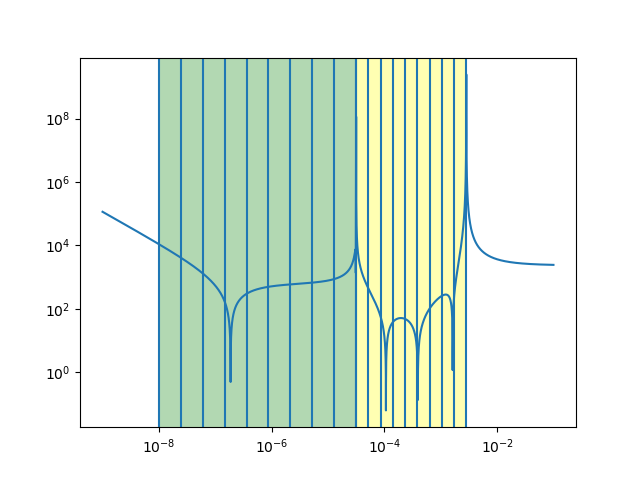

In [34]:
Ds = np.empty(ss.shape)
for i,s in enumerate(ss):
    Ds[i] = eva_Det(s,n)
    
fig,ax = plt.subplots()
ax.loglog(abs(ss),abs(Ds))
ax.axvline(1/maxwell_litho,color="red",linewidth=0.5)
ax.axvline(1/maxwell_mantle,color="red",linewidth=0.5)

eps = 0.00000001
span0 = np.array([-1/maxwell_litho-eps,-1/maxwell_mantle+eps])
span1 = np.array([-eps,-1/maxwell_litho+eps])
ax.axvspan(*abs(span0),color="yellow",linewidth=0.5,alpha=0.3)
ax.axvspan(*abs(span1),color="green",linewidth=0.5,alpha=0.3)

grid0 = np.exp(np.linspace(*np.log(abs(span0)),10))

for gr in grid0:
    ax.axvline(gr)
    
grid1 = np.exp(np.linspace(*np.log(abs(span1)),10))

for gr in grid1:
    ax.axvline(gr)

In [35]:
c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho = get_param_litho()           
c,m,b,density_mantle,gravity_mantle,gravity_core,shear_mantle,maxwell_mantle = get_param_mantle()
maxwells = [maxwell_litho,maxwell_mantle]

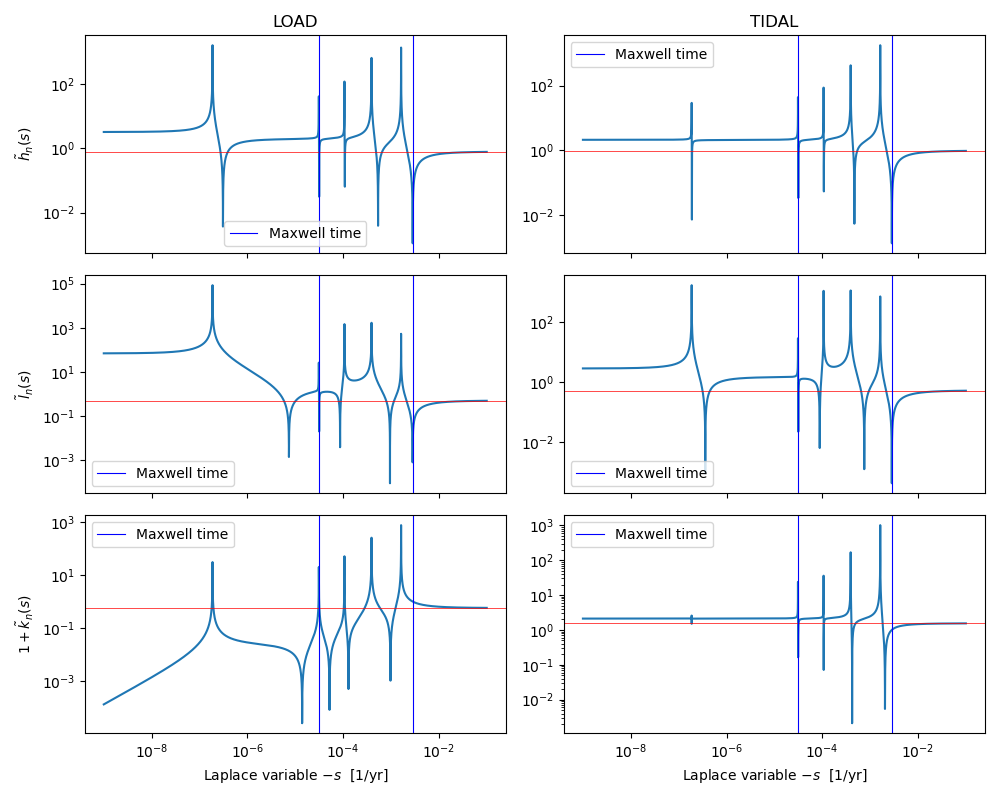

In [36]:
Ks = np.empty(ss.shape+(6,))
for i,s in enumerate(ss):
    Ks[i] = eva_Loves(s,n)
    
KE = eva_Loves(np.inf,n)

import matplotlib.pyplot as plt
fig,axes = plt.subplots(3,2,tight_layout=True,sharex=True,figsize=(10,8))
axes = axes.T.flatten()
for k,ax in enumerate(axes):
    ax.loglog(-ss,abs(Ks[:,k]))
    ax.axhline(abs(KE[k]),color="red",linewidth=0.5)

label_Loves(axes,maxwells)

In [37]:
Ds = []
for s in ss:
    D = eva_Det(s,n)
    Ds.append(D)
Ds = np.array(Ds)

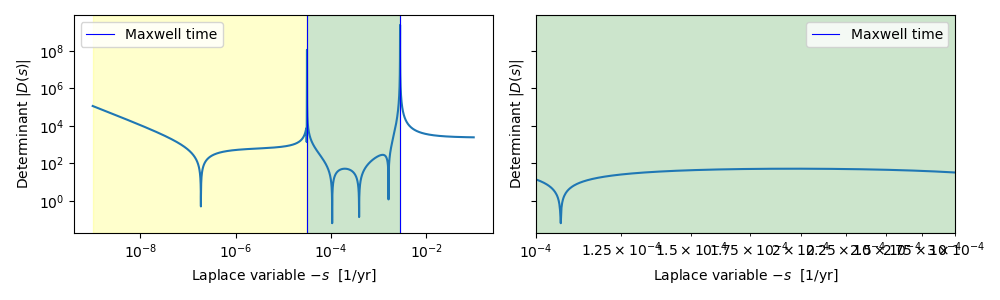

In [38]:
delta = 1e-9
spans = [ [-delta,-1/maxwell_litho+delta], [-1/maxwell_litho-delta,-1/maxwell_mantle+delta] ]

fig,axes = plt.subplots(1,2,tight_layout=True,sharey=True,figsize=(10,3))
axes[-1].set_xlim(1e-4,3e-4)

for ax in axes:
    ax.loglog(-ss,abs(Ds))
    label_Det(ax,maxwells)

    for color,span in zip(["yellow","green"],spans):
        ax.axvspan(-span[0],-span[1],alpha=0.2,color=color)

In [39]:
Nroots = 5
if n == 1: Nroots = 3
Nspan = 20
count = 0
while (count < Nroots):
    roots = []
    for span in spans:
        sext = np.linspace(*span,Nspan)
        for smin,smax in zip(sext,sext[1:]):
            if np.sign(eva_Det(smin,n))*np.sign(eva_Det(smax,n)) < 0:
                root = optimize.brentq(eva_Det,smin,smax,args=(n,))
                roots.append(root)
                #print(root)
    count = len(roots)
    Nspan *= 2
        
roots = np.array(roots)
roots.sort()


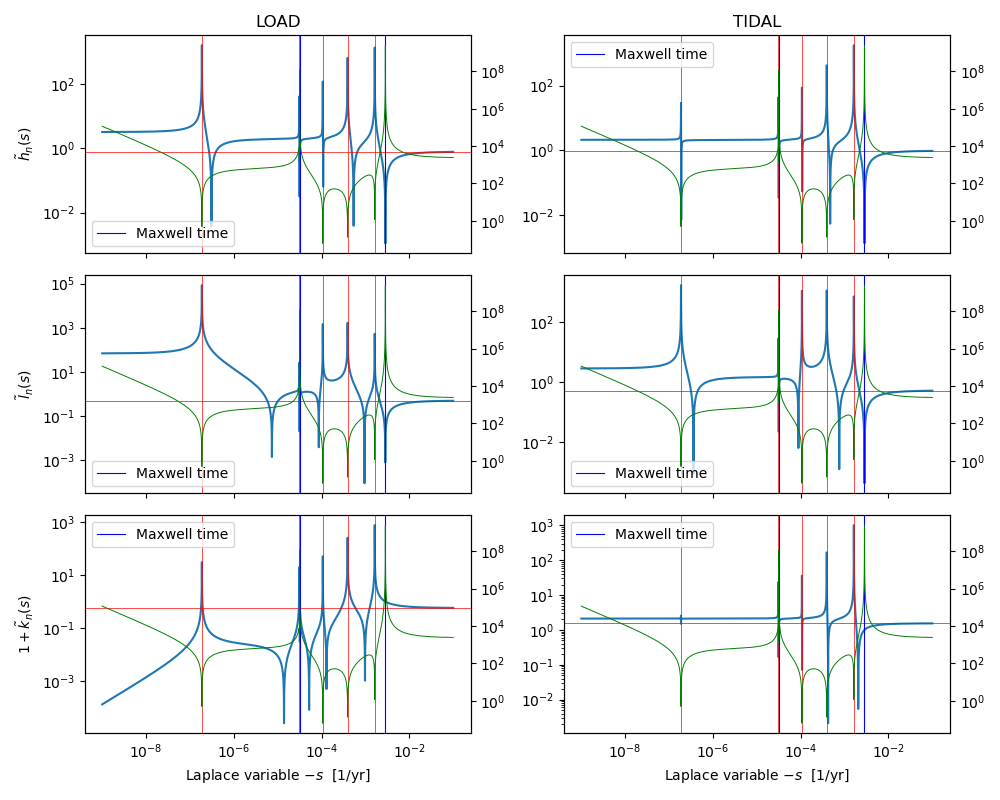

In [40]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(3,2,tight_layout=True,sharex=True,figsize=(10,8))
axes = axes.T.flatten()
for k,ax in enumerate(axes):
    ax.loglog(-ss,abs(Ks[:,k]))
    ax.axhline(abs(KE[k]),color="red",linewidth=0.5)
    
    for root in roots:
        ax.axvline(-root,color="red",linewidth=0.5)

    ax = ax.twinx()
    ax.loglog(-ss,abs(Ds),color="green",linewidth=0.7)

label_Loves(axes,maxwells)

In [41]:
eps = 1e-9
DERs = np.empty(len(roots))
for k,root in enumerate(roots):
    DERs[k] = eva_Det(root,n,eps)
print(roots)
relax_times = -1/roots

[-0.00163 -0.00039 -0.00011 -0.00003 -0.     ]


In [42]:
Rs = np.empty(roots.shape+(6,))
for k,root in enumerate(roots):
    Rs[k] = eva_Num(root,n)
    Rs[k] = Rs[k]/DERs[k]
KE = eva_Loves(np.inf,n)

In [43]:
Ks_check = np.zeros(ss.shape+(6,))
for k,root in enumerate(roots):
    Ks_check += np.tensordot(1/(ss-root),Rs[k],axes=0)
Ks_check += KE

KF = KE-(Rs.T/roots).sum(axis=-1)
print("KF:",KF)

KF: [ -3.16884 -69.97176   0.        2.11151   2.82933   2.11151]


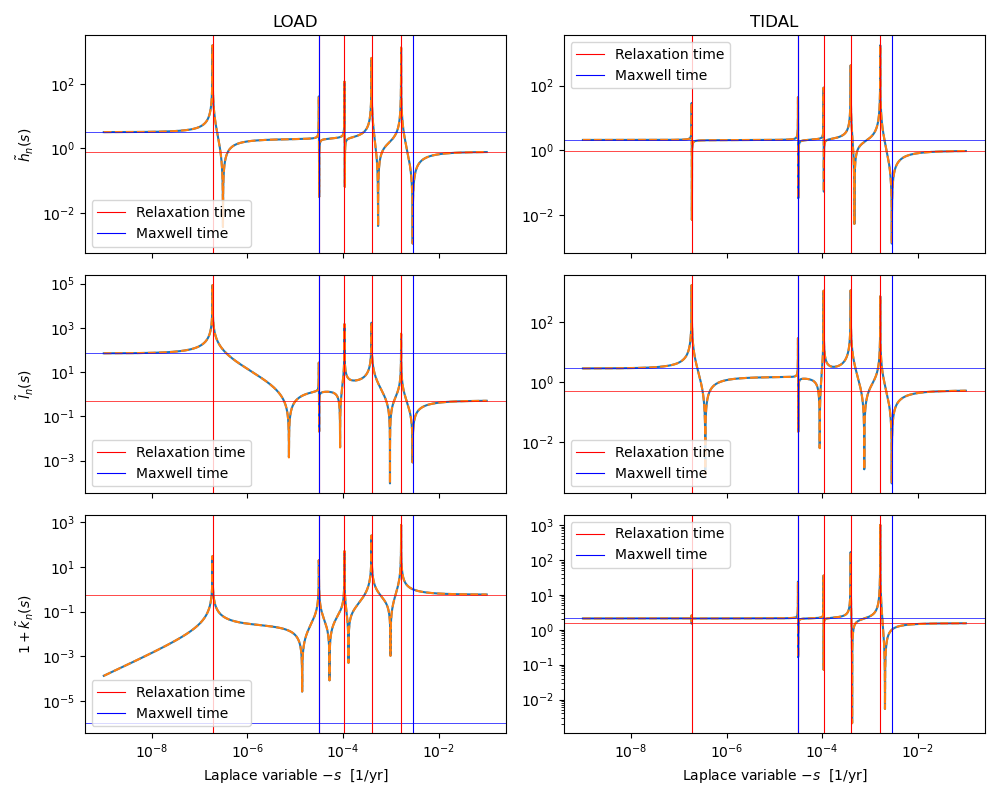

In [44]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(3,2,tight_layout=True,sharex=True,figsize=(10,8))
axes = axes.T.flatten()

for k,ax in enumerate(axes):
    ax.loglog(-ss,abs(Ks[:,k]))
    ax.loglog(-ss,abs(Ks_check[:,k]),linestyle="dashed")
    
    ax.axhline(abs(KE[k]),linewidth=0.5,color="red")
    ax.axhline(abs(KF[k]),linewidth=0.5,color="blue")

    ax.axvline(1/maxwell_litho,linewidth=0.5,color="blue")
    ax.axvline(1/maxwell_mantle,linewidth=0.5,color="blue")
    ax.axhline(0,linewidth=0.5,color="black")

label_Loves(axes,maxwells,relax_times)

In [45]:
ts = 1e1**np.linspace(-2,9,1001)

K_times = np.zeros(ts.shape+(6,))

for k,root in enumerate(roots):
    K_times += np.tensordot(1-np.exp(root*ts),-Rs[k]/root,axes=0) 
    
K_times += KE

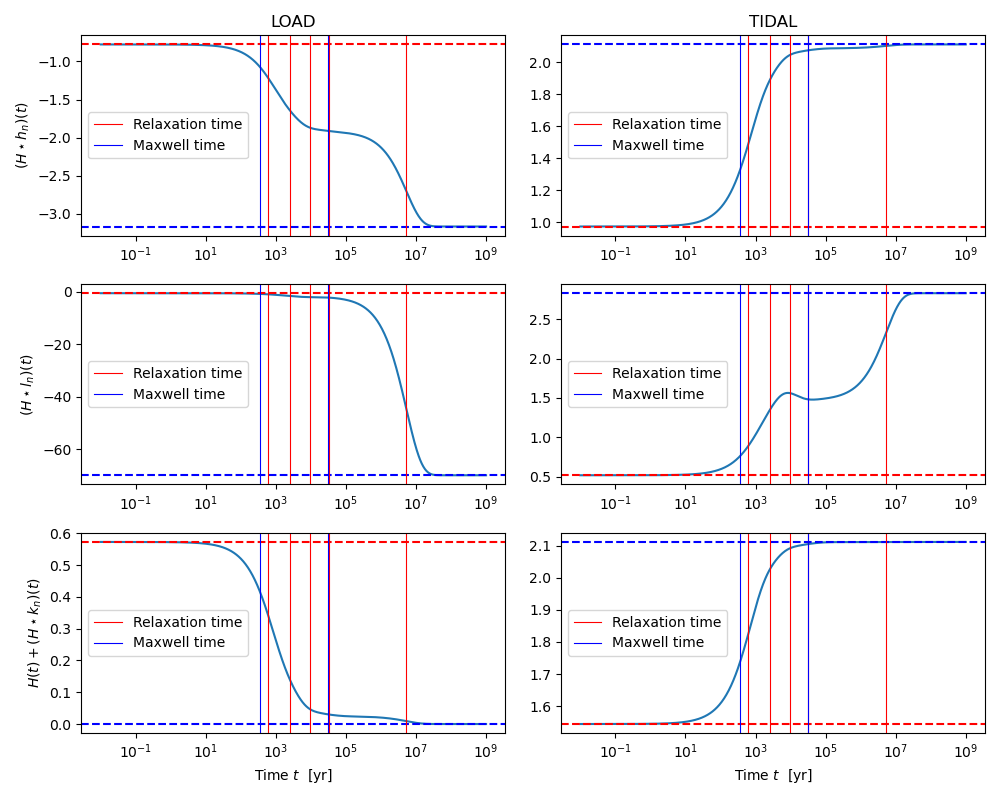

In [46]:
fig,axes = plt.subplots(3,2,tight_layout=True,figsize=(10,8))
axes = axes.T.flatten()

for k,ax in enumerate(axes):
    ax.semilogx(ts,K_times[:,k])
    ax.axhline(KE[k],color="red",linestyle="dashed")
    ax.axhline(KF[k],color="blue",linestyle="dashed")
        
label_Loves(axes,maxwells,relax_times,True)

## Surface loading

In [47]:
n_max = 200
delta = 1e-9
spans = [ [-delta,-1/maxwell_litho+delta], [-1/maxwell_litho-delta,-1/maxwell_mantle+delta] ]
deg_roots = {}

In [48]:
for n in range(1,n_max+1):
    
    Nroots = 5
    if n == 1: Nroots = 3
    Nspan = 20
    count = 0
    while (count < Nroots):
        roots = []
        for span in spans:
            sext = np.linspace(*span,Nspan)
            for smin,smax in zip(sext,sext[1:]):
                if np.sign(eva_Det(smin,n))*np.sign(eva_Det(smax,n)) < 0:
                    root = optimize.brentq(eva_Det,smin,smax,args=(n,))
                    roots.append(root)
        count = len(roots)
        Nspan *= 2
        
    roots = np.array(roots)
    roots.sort()
    deg_roots[n] = roots.copy()   

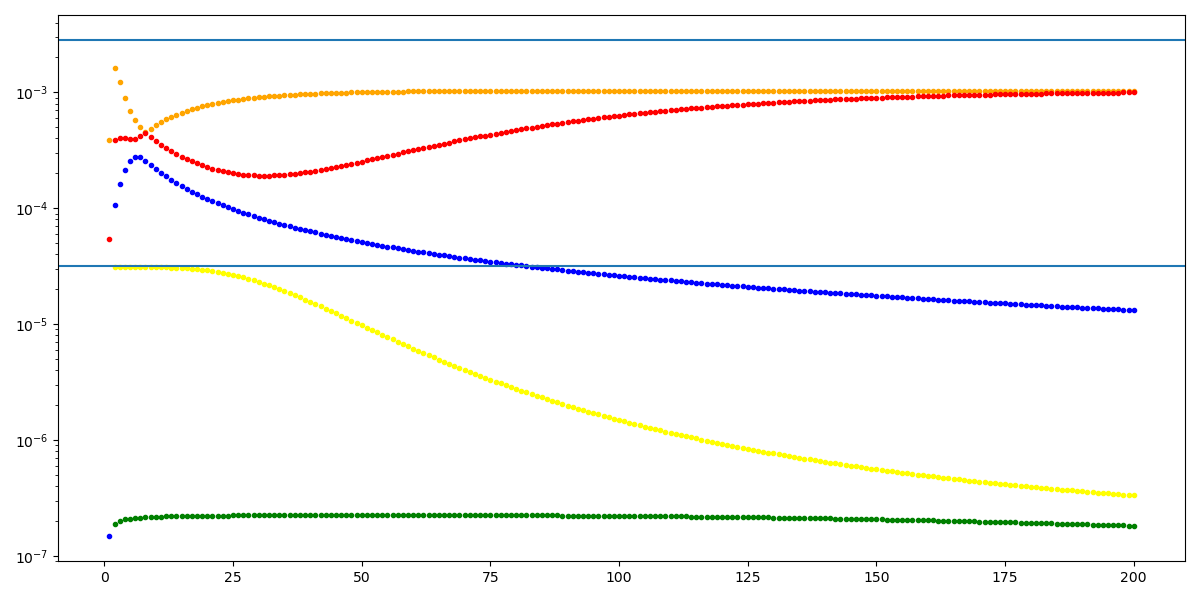

In [49]:
colors = ["orange","red","blue","yellow","green"]
fig, ax = plt.subplots(tight_layout=True,figsize=(12,6))
for n,roots in deg_roots.items():
    for root,color in zip(roots,colors):
        ax.scatter(n,-root,marker=".",color=color)
for maxwell in maxwells:
    ax.axhline(1/maxwell)
ax.set_yscale("log")

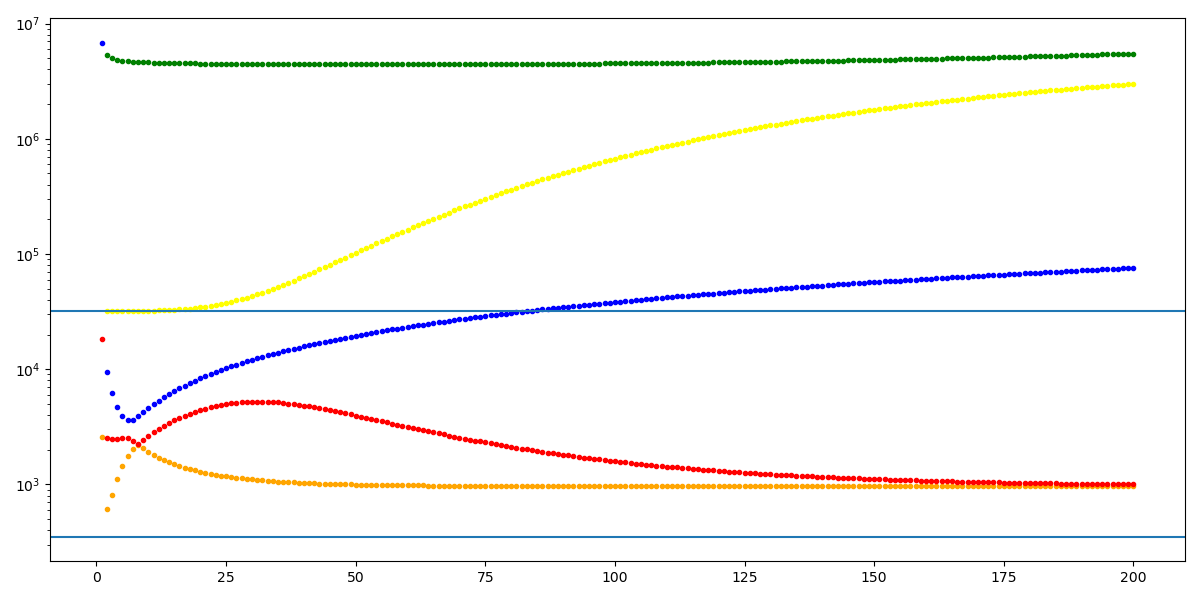

In [50]:
colors = ["orange","red","blue","yellow","green"]
fig, ax = plt.subplots(tight_layout=True,figsize=(12,6))
for n,roots in deg_roots.items():
    for root,color in zip(roots,colors):
        ax.scatter(n,-1/root,marker=".",color=color)
for maxwell in maxwells:
    ax.axhline(maxwell)
ax.set_yscale("log")

In [51]:
ts = 1e1**np.linspace(-2,9,1301)

KE_degrees = np.zeros((6,n_max+1))
KF_degrees = np.zeros((6,n_max+1))
K_times_degrees = np.zeros(ts.shape+(6,n_max+1))

KE_degrees[[2,5],0] = 1
KF_degrees[[2,5],0] = 1
K_times_degrees[:,[2,5],0] = 1

for n,roots in deg_roots.items():
        
    K_times = np.empty(ts.shape+(6,))
    Rs = np.empty(roots.shape+(6,))
    DERs = np.empty(len(roots))

    eps = 1e-8
    for k,root in enumerate(roots):
        DERs[k] = eva_Det(root,n,eps)
    relax_times = -1/roots
    
    for k,root in enumerate(roots):
        Rs[k] = eva_Num(root,n)
        Rs[k] = Rs[k]/DERs[k]
            
    K_times.fill(0)
    for k,root in enumerate(roots):
        K_times += np.tensordot(1-np.exp(root*ts),-Rs[k]/root,axes=0) 

    KE = eva_Loves(np.inf,n)
    K_times += KE
        
    KF = KE-(Rs.T/roots).sum(axis=-1)
    
    KE_degrees[:,n] = KE.copy()
    KF_degrees[:,n] = KF.copy()
    K_times_degrees[:,:,n] = K_times.copy()

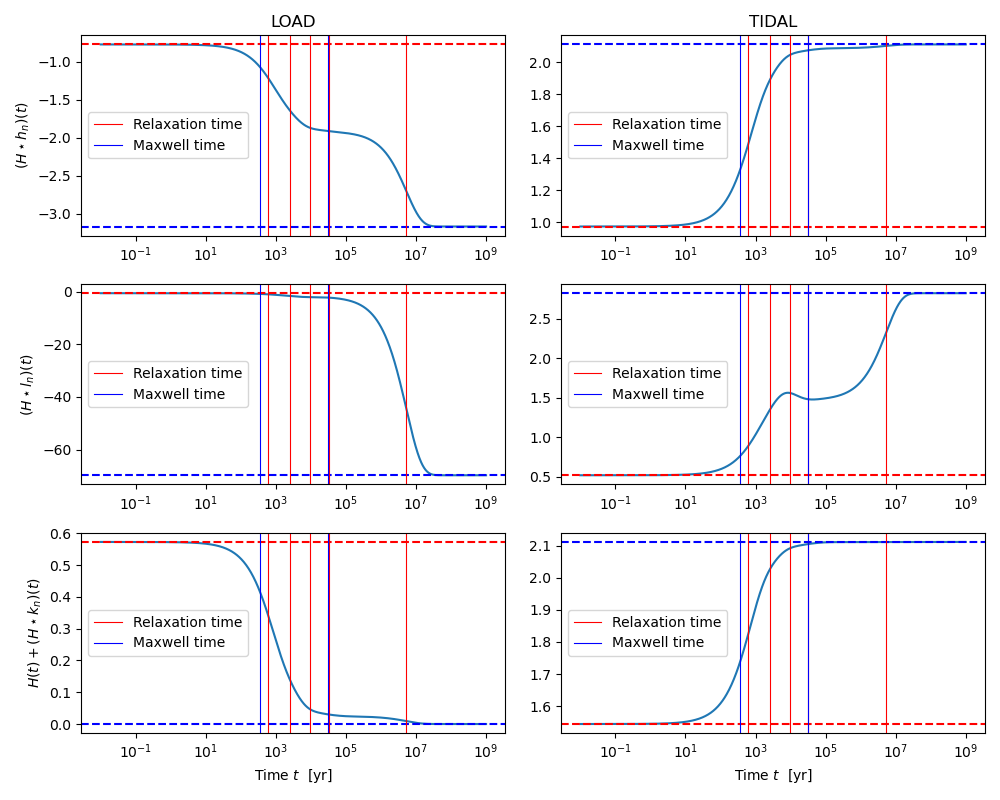

In [52]:
n = 2
relax_times = -1/deg_roots[n]
K_times = K_times_degrees[:,:,n]
KE = KE_degrees[:,n]
KF = KF_degrees[:,n]

fig,axes = plt.subplots(3,2,tight_layout=True,figsize=(10,8))
axes = axes.T.flatten()
for k,ax in enumerate(axes):
    ax.semilogx(ts,K_times[:,k])
    ax.axhline(KE[k],color="red",linestyle="dashed")
    ax.axhline(KF[k],color="blue",linestyle="dashed")

label_Loves(axes,maxwells,relax_times,True)

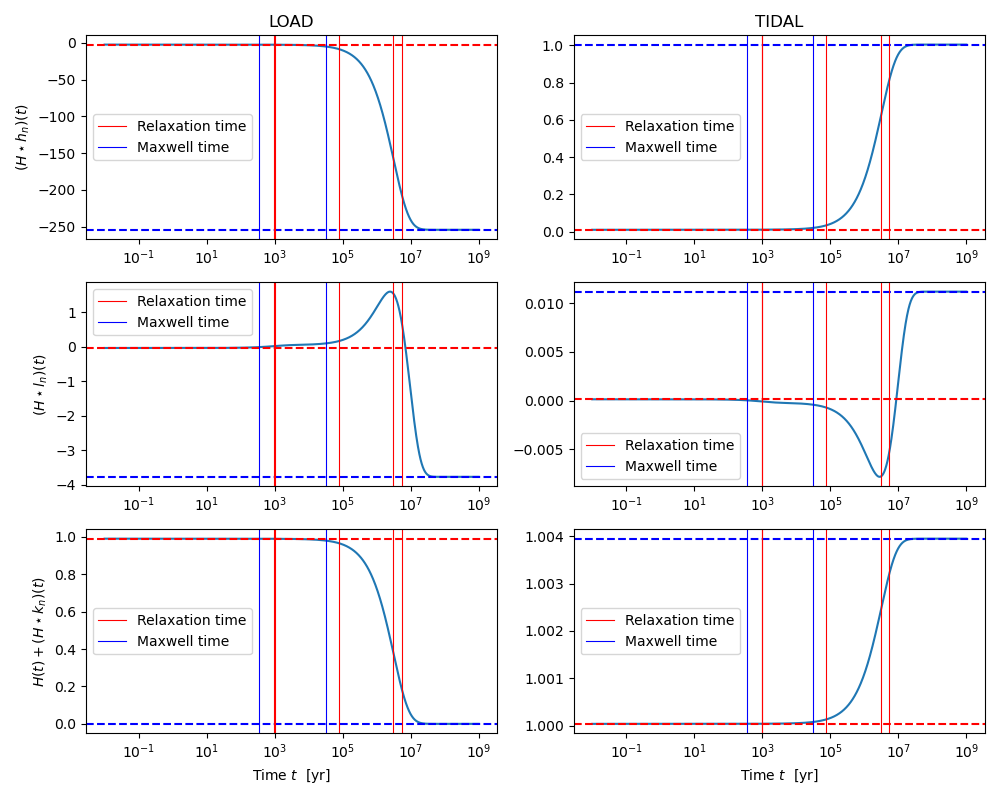

In [53]:
n = 200
relax_times = -1/deg_roots[n]
K_times = K_times_degrees[:,:,n]
KE = KE_degrees[:,n]
KF = KF_degrees[:,n]

fig,axes = plt.subplots(3,2,tight_layout=True,figsize=(10,8))
axes = axes.T.flatten()
for k,ax in enumerate(axes):
    ax.semilogx(ts,K_times[:,k])
    ax.axhline(KE[k],color="red",linestyle="dashed")
    ax.axhline(KF[k],color="blue",linestyle="dashed")

label_Loves(axes,maxwells,relax_times,True)

In [54]:
(6371*2*np.pi)/100

400.30173592041143

In [55]:
HF = KF_degrees[0]
H_times = K_times_degrees[:,0,:]
print(HF.shape)
print(H_times.shape)

(201,)
(1301, 201)


In [56]:
import numpy as np
import matplotlib.pyplot as plt

def eva_Pn(z,N):
    Pn = np.empty(N+1)
    Pn[0] = 1
    Pn[1] = z
    for n in range(1,N):
        Pn[n+1] = ( (2*n+1)*z*Pn[n]-n*Pn[n-1] ) / (n+1)
    return Pn

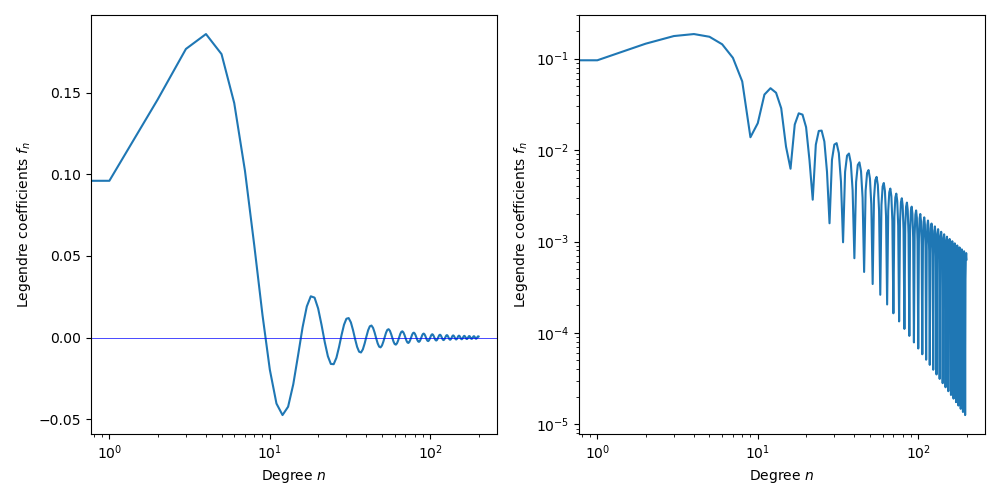

In [57]:
alpha = 30

dtr = np.pi/180
aa = np.cos(alpha*dtr)

N = 200
Pn = eva_Pn(aa,N+1)

fn = np.empty(N+1)

fn[0] = (1-aa)/4
fn[1] = (1-aa)*(2+aa)/4 
for n in range(2,N+1):
    fn[n] = (2*n+1)/(2*n*(n-1)*(2+n)*(1-aa)) * ( ( aa**2*(2+n) - n ) * Pn[n] - 2 * aa * Pn[n+1]) 

fig,axes = plt.subplots(1,2,tight_layout=True,sharex=True,figsize=(10,5))
axes[0].semilogx(fn)
axes[1].loglog(abs(fn))
for ax in axes:
    ax.axhline(0,color="b",linewidth=0.5)
    ax.set_ylabel("Legendre coefficients $f_n$")
    ax.set_xlabel("Degree $n$")

In [58]:
gamma = np.linspace(0,180,18001)
zs = np.cos(gamma*dtr)

function = np.zeros(gamma.shape)
function = (zs-aa)/(1-aa)
function[zs<aa] = 0

In [59]:
def eva_Pns(zs,N):
    Pns = np.empty(zs.shape+(N+1,))
    Pns[:,0] = 1
    Pns[:,1] = zs
    for n in range(1,N):
        Pns[:,n+1] = ( (2*n+1)*zs*Pns[:,n]-n*Pns[:,n-1] ) / (n+1)
    return Pns

Pns = eva_Pns(zs,N)

In [60]:
N

200

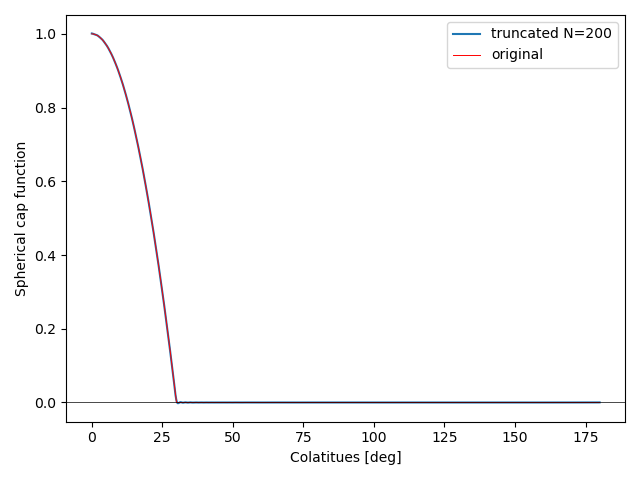

In [61]:
truncated_function = Pns @ fn 

%matplotlib widget
fig,ax=plt.subplots(tight_layout=True)
ax.plot(gamma,truncated_function,label="truncated N="+str(N))
ax.plot(gamma,function,label="original",color="red",linewidth=0.7)
ax.axhline(0,color="black",linewidth=0.5)
ax.set_ylabel("Spherical cap function")
ax.set_xlabel("Colatitues [deg]")
ax.legend();

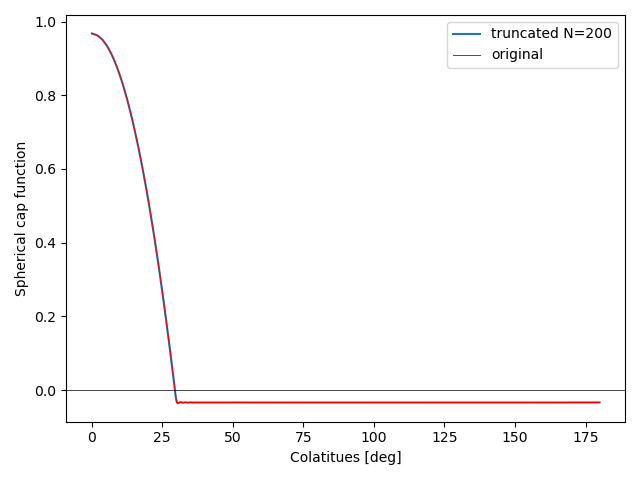

In [62]:
function -= fn[0]
fn[0] = 0
truncated_function = Pns @ fn 

fig,ax=plt.subplots(tight_layout=True)
ax.plot(gamma,truncated_function,label="truncated N="+str(N))
ax.plot(gamma,function,label="original",color="red",linewidth=0.7)
ax.axhline(0,color="black",linewidth=0.5)
ax.set_ylabel("Spherical cap function")
ax.set_xlabel("Colatitues [deg]")
ax.legend();

In [63]:
Hs = K_times_degrees[:,0,:]

In [64]:
c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho = get_param_litho()    
print(c,a,m,density_litho,gravity_litho,gravity_mantle,shear_litho,maxwell_litho)

12.158297517383929 1.0 0.9811646523308742 0.6 4.623368339817915 4.66252303633057 0.7142857142857143 31688.087814028946



$$
\phi_{n,m}(r) = A^+_{n,m}\,r^n = \phi_{n,m}(r_S)\,\left(\frac{r}{r_S}\right)^n = -\frac{c\,\sigma_{n,m}\,r_S}{2\,n+1}\,\left(\frac{r}{r_S}\right)^n \qquad\mathrm{with}\qquad r\leq r_S
$$


$$
\phi_{n,m}(a) =  -\frac{c\,\sigma_{n,m}\,a}{2\,n+1} 
$$


In [65]:
Gn = np.empty(fn.shape)

DENSITY = 5000
LENGHT = 6371e3

density_ice = 1000 / DENSITY
for n,f in enumerate(fn):
    Gn[n] = a * f * density_ice * c / gravity_litho / (2*n+1) 

In [66]:
geoid = Pns @ Gn 

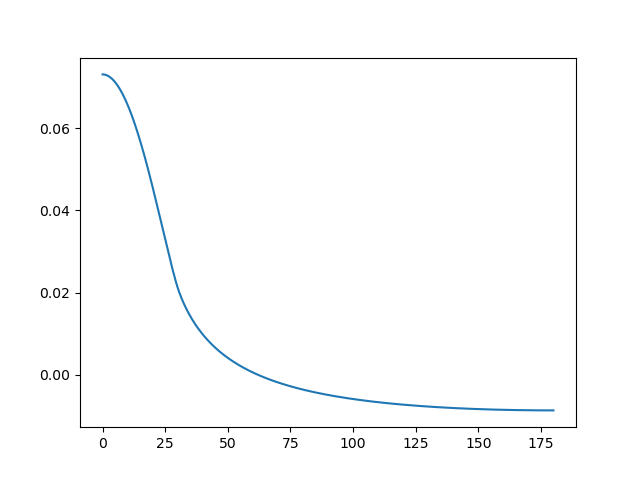

In [67]:
fig,ax=plt.subplots()
ax.plot(gamma,geoid)

In [68]:
HF = KF_degrees[0]
H_times = K_times_degrees[:,0,:]
print(HF.shape)
print(H_times.shape)

(201,)
(1301, 201)


In [69]:
HGn = (HF * Gn).T 
HGn_times = (H_times * Gn).T 

In [70]:
UF = Pns @ HGn
U_times = Pns @ HGn_times

In [71]:
print(gamma.shape)
print(UF.shape)
print(U_times.shape)

(18001,)
(18001,)
(18001, 1301)


In [72]:
ts[-1]/1e9

1.0

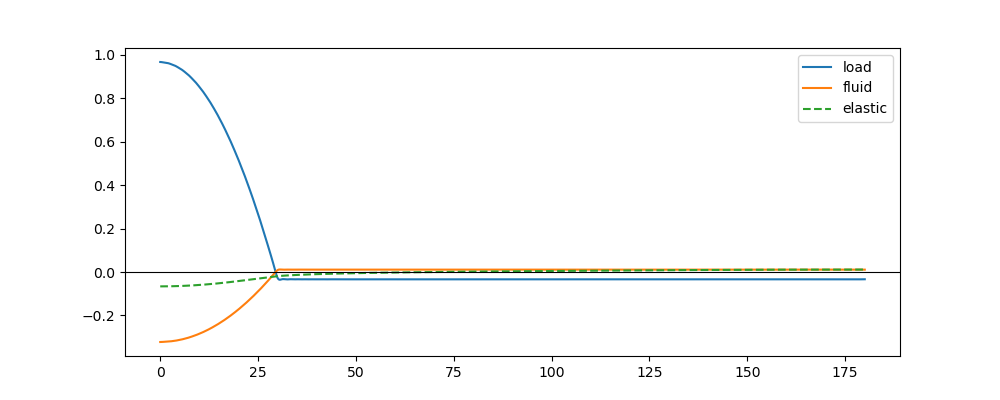

In [73]:
fig,ax=plt.subplots(figsize=(10,4))
ax.plot(gamma,truncated_function,label="load")
ax.plot(gamma,UF,label="fluid")
ax.plot(gamma,U_times[:,0],label="elastic",linestyle="dashed")
#ax.plot(gamma,U_times[:,-1],label="time",linestyle="dashed")
ax.axhline(0,color="black",linewidth=0.8)
ax.legend();

In [74]:
density_litho / density_ice

2.9999999999999996

/var/folders/_1/qb7nz8z90qngdj_k_1kjbcyh0000gn/T/ipykernel_6186/2880744174.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


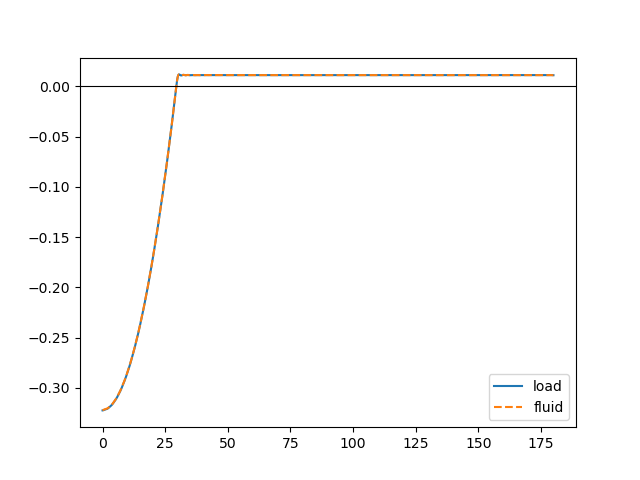

In [75]:
fig,ax=plt.subplots()
ax.plot(gamma,-truncated_function*(density_ice/density_litho),label="load")
ax.plot(gamma,UF,label="fluid",linestyle="dashed")
ax.axhline(0,color="black",linewidth=0.8)
ax.legend();